In [54]:
import pandas as pd
import random
import seaborn as sns
sns.set()
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Data

In [55]:
files = ['vanilla_sample_random_equal_t1.csv', \
         'vanilla_sample_high_conf_equal.csv', \
         'vanilla_sample_random_men.csv', \
         'vanilla_sample_random_women.csv'
        ]

In [56]:
dfs = []
for file in files:
    data = []
    for line in open(file, 'rt'):
        line = line.split('\t')
        label = line[0]

        second = line[1].strip('!').split('<|endoftext|>')
        q = second[0]
        r = second[1]

        data.append((label, q, r))
    df = pd.DataFrame(data, columns=['label', 'question', 'response'])
    dfs.append((file, df))

In [4]:
def precision_full_response(x):
    keywords = ['yes', 'ok', 'sure', 'no', 'nope', 'nah']
    return any(i in x.lower() for i in keywords)

In [23]:
for file, df in dfs:
    df['has_full'] = df.response.apply(lambda x: precision_full_response(x))

### Statistical tests

100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]


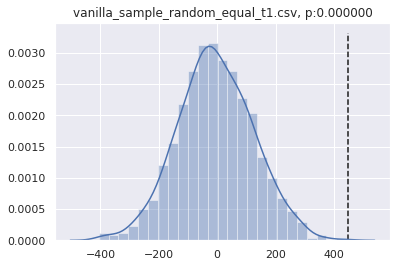

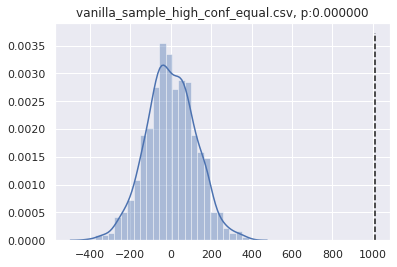

In [45]:
trials = 1000

for file, df in dfs[:2]:    
    diffs = []
    
    #test statistic
    counts = df.groupby('label').has_full.value_counts()
    test_diff = counts['W'][True] - counts['M'][True]
    
    for i in tqdm(range(0, trials)):
        df['randomized_label'] = random.sample(df['label'].tolist(), len(df['label']))
        counts = df.groupby('randomized_label').has_full.value_counts()
        diff = counts['W'][True] - counts['M'][True]
        diffs.append(diff) 
    
    diffs = np.array(diffs)
    p_value = sum(np.abs(diffs) > test_diff) / trials

    plt.figure()
    plt.title('%s, p:%f' % (file, p_value))
    ax = sns.distplot(diffs)
    ymin, ymax = ax.get_ylim()
    ax.vlines(test_diff, ymin, ymax, linestyle='--')

100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]


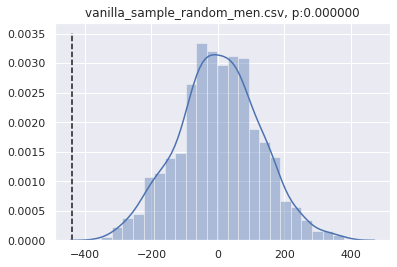

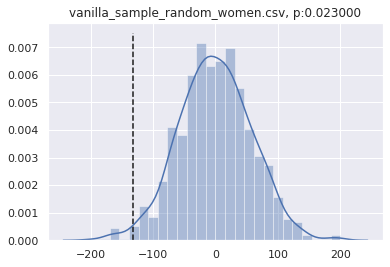

In [53]:
trials = 1000

for file, df in dfs[2:]:    
    diffs = []
    
    # sort high and low
    df['label'] = df['label'].astype(float)
    df['is_high'] = pd.qcut(df['label'], 2, labels=['lo', 'hi'])
    
    #test statistic
    counts = df.groupby('is_high').has_full.value_counts()
    test_diff = counts['lo'][True] - counts['hi'][True]
    
    for i in tqdm(range(0, trials)):
        df['randomized_label'] = random.sample(df['is_high'].tolist(), len(df['is_high']))
        counts = df.groupby('randomized_label').has_full.value_counts()
        diff = counts['lo'][True] - counts['hi'][True]
        diffs.append(diff) 
    
    diffs = np.array(diffs)
    p_value = sum(np.abs(diffs) > np.abs(test_diff)) / trials

    plt.figure()
    plt.title('%s, p:%f' % (file, p_value))
    ax = sns.distplot(diffs)
    ymin, ymax = ax.get_ylim()
    ax.vlines(test_diff, ymin, ymax, linestyle='--')